In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd

dataset = pd.read_csv('B20000017_Seif_Assignment3.csv')

In [71]:
rating_min, rating_max = dataset['rating'].min(), dataset['rating'].max()
assert 1 <= rating_min and rating_max <= 5, "Ratings are not within the 1-to-5 scale."

In [72]:
Tnu = dataset['userId'].nunique()
Tni = dataset['movieId'].nunique()

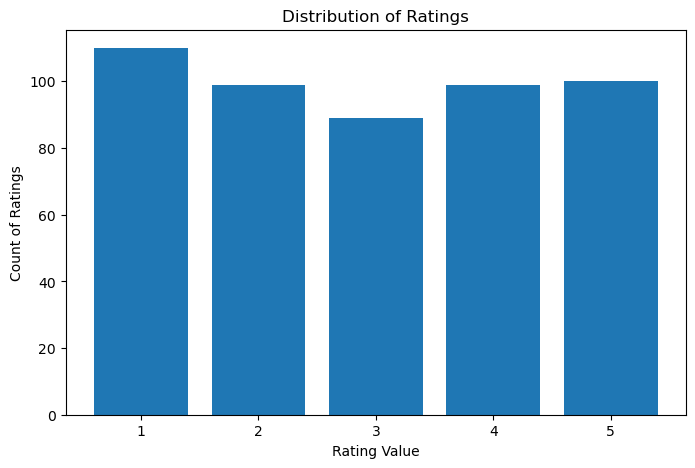

In [73]:
ratings_per_item = dataset['movieId'].value_counts()

rating_distribution = dataset['rating'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
plt.bar(rating_distribution.index, rating_distribution.values, tick_label=rating_distribution.index)
plt.title("Distribution of Ratings")
plt.xlabel("Rating Value")
plt.ylabel("Count of Ratings")
plt.show()

In [74]:
total_possible_ratings = Tnu * Tni
actual_ratings = len(dataset)
sparsity = 1 - (actual_ratings / total_possible_ratings)
rating_bias = (rating_distribution / rating_distribution.sum()).max()

In [75]:
lowest_rated_items = dataset.groupby('movieId')['rating'].mean().nsmallest(2)
I1, I2 = lowest_rated_items.index.tolist()

In [76]:
lowest_rated_items = dataset.groupby('movieId')['rating'].mean().nsmallest(2)
I1, I2 = lowest_rated_items.index.tolist()

In [77]:
# PCA with Mean-Filling
mean_I1 = dataset.loc[dataset['movieId'] == I1, 'rating'].mean()
mean_I2 = dataset.loc[dataset['movieId'] == I2, 'rating'].mean()

In [78]:
user_item_matrix = dataset.pivot_table(index='userId', columns='movieId', values='rating')
user_item_matrix[I1] = user_item_matrix[I1].fillna(mean_I1)
user_item_matrix[I2] = user_item_matrix[I2].fillna(mean_I2)

In [79]:
item_means = user_item_matrix.mean()

rating_diffrences = user_item_matrix.subtract(item_means, axis=1)

covariance_matrix = rating_diffrences.cov()

In [80]:
peers_I1 = covariance_matrix[I1].sort_values(ascending=False).iloc[1:11]
peers_I2 = covariance_matrix[I2].sort_values(ascending=False).iloc[1:11]

In [81]:
top_5_peers_I1 = peers_I1.iloc[:5]
top_5_peers_I2 = peers_I2.iloc[:5]

In [82]:
reduced_matrix_5_I1 = user_item_matrix[top_5_peers_I1.index]
reduced_matrix_5_I2 = user_item_matrix[top_5_peers_I2.index]

In [83]:
predicted_rating_5_I1 = reduced_matrix_5_I1.mean(axis=1)
predicted_rating_5_I2 = reduced_matrix_5_I2.mean(axis=1)

In [84]:
reduced_matrix_10_I1 = user_item_matrix[peers_I1.index]
reduced_matrix_10_I2 = user_item_matrix[peers_I2.index]

In [85]:
predicted_rating_10_I1 = reduced_matrix_10_I1.mean(axis=1)
predicted_rating_10_I2 = reduced_matrix_10_I2.mean(axis=1)

In [86]:
comparison_I1 = pd.DataFrame({
    'Top 5 Prediction': predicted_rating_5_I1,
    'Top 10 Prediction': predicted_rating_10_I1
})
comparison_I2 = pd.DataFrame({
    'Top 5 Prediction': predicted_rating_5_I2,
    'Top 10 Prediction': predicted_rating_10_I2
})

print("Comparison for I1:")
print(comparison_I1)
print("\nComparison for I2:")
print(comparison_I2)

Comparison for I1:
         Top 5 Prediction  Top 10 Prediction
userId                                      
User_1           2.666667           2.939130
User_10          4.666667           3.571429
User_11          2.000000           2.500000
User_12          2.333333           2.939130
User_13          3.000000           3.527950
User_14          2.750000           2.555556
User_15          2.500000           2.339130
User_16          1.500000           2.139130
User_17          2.500000           2.449275
User_18          1.500000           1.500000
User_19               NaN           4.173913
User_2           3.000000           2.939130
User_20          4.000000           3.800000
User_21          3.000000           2.750000
User_22          3.000000           3.139130
User_23          3.000000           3.423913
User_24          3.000000           2.500000
User_25               NaN           3.000000
User_26          3.666667           3.782609
User_27          4.750000           

In [87]:
# Part 2: PCA with (MLE)
mle_covariance_matrix = pd.DataFrame(index=user_item_matrix.columns, columns=user_item_matrix.columns)
for item1 in user_item_matrix.columns:
    for item2 in user_item_matrix.columns:
        common_users = user_item_matrix[[item1, item2]].dropna()
        if len(common_users) > 1:
            mle_covariance_matrix.loc[item1, item2] = common_users.cov().iloc[0, 1]
        else:
            mle_covariance_matrix.loc[item1, item2] = 0.0

mle_covariance_matrix = mle_covariance_matrix.astype(float)



In [88]:
mle_peers_I1 = mle_covariance_matrix[I1].sort_values(ascending=False).iloc[1:11]
mle_peers_I2 = mle_covariance_matrix[I2].sort_values(ascending=False).iloc[1:11]


mle_top_5_peers_I1 = mle_peers_I1.iloc[:5]
mle_top_5_peers_I2 = mle_peers_I2.iloc[:5]

In [89]:
mle_reduced_matrix_5_I1 = user_item_matrix[mle_top_5_peers_I1.index]
mle_reduced_matrix_5_I2 = user_item_matrix[mle_top_5_peers_I2.index]

mle_predicted_rating_5_I1 = mle_reduced_matrix_5_I1.mean(axis=1)
mle_predicted_rating_5_I2 = mle_reduced_matrix_5_I2.mean(axis=1)

In [90]:
mle_reduced_matrix_10_I1 = user_item_matrix[mle_peers_I1.index]
mle_reduced_matrix_10_I2 = user_item_matrix[mle_peers_I2.index]

mle_predicted_rating_10_I1 = mle_reduced_matrix_10_I1.mean(axis=1)
mle_predicted_rating_10_I2 = mle_reduced_matrix_10_I2.mean(axis=1)

In [91]:
mle_comparison_I1 = pd.DataFrame({
    'Top 5 Prediction (MLE)': mle_predicted_rating_5_I1,
    'Top 10 Prediction (MLE)': mle_predicted_rating_10_I1
})
mle_comparison_I2 = pd.DataFrame({
    'Top 5 Prediction (MLE)': mle_predicted_rating_5_I2,
    'Top 10 Prediction (MLE)': mle_predicted_rating_10_I2
})

print("MLE Comparison for I1:")
print(mle_comparison_I1)
print("\nMLE Comparison for I2:")
print(mle_comparison_I2)

MLE Comparison for I1:
         Top 5 Prediction (MLE)  Top 10 Prediction (MLE)
userId                                                  
User_1                 2.666667                 2.939130
User_10                4.666667                 3.571429
User_11                2.000000                 2.500000
User_12                2.333333                 2.939130
User_13                3.000000                 3.527950
User_14                2.750000                 2.555556
User_15                2.500000                 2.339130
User_16                1.500000                 2.139130
User_17                2.500000                 2.449275
User_18                1.500000                 1.500000
User_19                     NaN                 4.173913
User_2                 3.000000                 2.939130
User_20                4.000000                 3.800000
User_21                3.000000                 2.750000
User_22                3.000000                 3.139130
User_23 

In [92]:
user_item_matrix = dataset.pivot_table(index='userId', columns='movieId', values='rating')


user_item_matrix = user_item_matrix.fillna(user_item_matrix.mean())


if np.any(np.isnan(user_item_matrix.to_numpy())) or np.any(np.isinf(user_item_matrix.to_numpy())):
    raise ValueError("User-item matrix contains NaN or Inf values after mean-filling.")

In [93]:
# Part 3:(SVD) Method
try:
    R = user_item_matrix.to_numpy()
    U, S, Vt = svd(R, full_matrices=False)
except ValueError as e:
    print("Error during SVD computation:", e)
    print("Attempting to clean the matrix and retry...")
    R = np.nan_to_num(R, nan=0.0, posinf=0.0, neginf=0.0)
    U, S, Vt = svd(R, full_matrices=False)

# Eigenvalues and Eigenvectors
eigenvalues = S**2 / (R.shape[0] - 1)
eigenvectors = Vt.T

In [94]:
orthogonality_check = np.allclose(np.dot(eigenvectors.T, eigenvectors), np.eye(eigenvectors.shape[1]))
assert orthogonality_check, "Eigenvectors are not orthogonal."


normalized_eigenvectors = eigenvectors / np.linalg.norm(eigenvectors, axis=0)

In [95]:
orthonormal_vectors = []
for i in range(normalized_eigenvectors.shape[1]):
    vi = normalized_eigenvectors[:, i]
    for uj in orthonormal_vectors:
        vi -= np.dot(uj, vi) * uj
    vi /= np.linalg.norm(vi)
    orthonormal_vectors.append(vi)
orthonormal_vectors = np.array(orthonormal_vectors).T

In [96]:
Sigma = np.diag(S)
U_hat = U[:, :len(Sigma)]
V_hat = Vt[:len(Sigma), :].T

In [97]:
R_hat = np.dot(U_hat, np.dot(Sigma, V_hat.T))

predicted_ratings_I1 = R_hat[:, user_item_matrix.columns.get_loc(I1)]
predicted_ratings_I2 = R_hat[:, user_item_matrix.columns.get_loc(I2)]

In [98]:
print("\nPredicted Ratings:")
print(f"I1 Predictions: {predicted_ratings_I1}")
print(f"I2 Predictions: {predicted_ratings_I2}")


Predicted Ratings:
I1 Predictions: [1.  4.  4.  2.6 2.6 1.  2.6 2.  2.6 2.6 1.  2.6 4.  4.  2.6 2.6 1.  2.
 4.  4.  2.  2.6 5.  2.6 2.6 2.6 2.6 2.6 2.  2.6 3.  1.  3.  2.6 2.6 2.
 2.6 5.  2.6 2.6 1.  3.  4.  2.6 2.6 2.6 1.  2.6 2.6 1. ]
I2 Predictions: [2.69565217 3.         4.         2.69565217 2.69565217 3.
 2.69565217 2.69565217 2.69565217 1.         2.69565217 2.69565217
 3.         3.         2.69565217 2.69565217 1.         5.
 2.69565217 2.69565217 2.         2.69565217 2.69565217 2.69565217
 3.         2.69565217 1.         4.         2.69565217 3.
 2.69565217 3.         2.         2.69565217 5.         2.69565217
 2.         2.69565217 2.69565217 2.69565217 2.69565217 1.
 3.         1.         2.69565217 2.69565217 1.         5.
 3.         2.69565217]
